In [127]:
import cv2
import time
import scipy.io as sio
import skimage
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

In [128]:
landmark_points_68 = [162,234,93,58,172,136,149,148,152,377,378,365,397,288,323,454,389,71,63,105,66,107,336,
                  296,334,293,301,168,197,5,4,75,97,2,326,305,33,160,158,133,153,144,362,385,387,263,373,
                  380,61,39,37,0,267,269,291,405,314,17,84,181,78,82,13,312,308,317,14,87]

mask_name = "cat" # "cat", "santa"

### Detect the Face using Haar Cascade Classifier

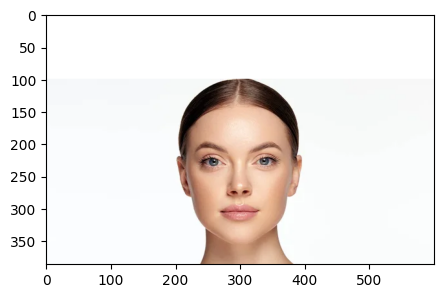

In [129]:
face = cv2.imread("../images/face.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
# identity affine matrix
# shift face downwards by 50 pixels
identity_affine = np.array([[1, 0, 0], [0, 1, 0]])
identity_affine = np.float64(identity_affine)
identity_affine[1, 2] += 100

# # Apply the affine transformation to the hat map
face = cv2.warpAffine(face, identity_affine, (face.shape[1], face.shape[0]))
face[0:100,:] = 255
plt.figure(figsize=(5, 5))
plt.imshow(face)
plt.show()

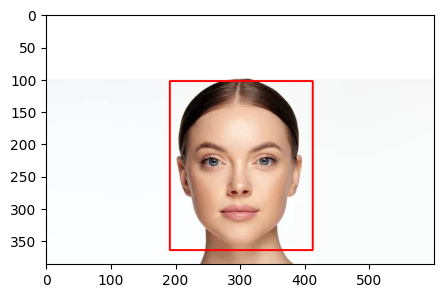

In [130]:
detector = cv2.CascadeClassifier("../data/haarcascade_frontalface_default.xml")
results = detector.detectMultiScale(face, 1.3, 5)
face_copy = np.copy(face)
for (x, y, w, h) in results:
    cv2.rectangle(face_copy, (x-10, y-40), (x+w+10, y+h+20), (255, 0, 0), 2)

plt.figure(figsize=(5, 5))
plt.imshow(face_copy)
plt.show()



### Segment the face


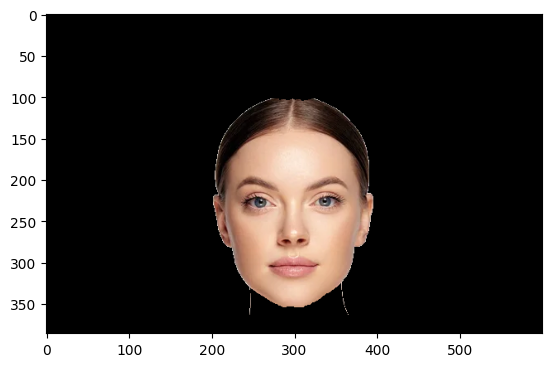

Total time taken for segmentation: 0.99 seconds


In [131]:
# segment out the face using grabcut
st = time.time()
bgModel = np.zeros((1, 65), np.float64)
fgModel = np.zeros((1, 65), np.float64)

mask = np.zeros(face.shape[:2], np.uint8)

rect = (results[0][0]-10, results[0][1]-40, results[0][2]+10, results[0][3]+60)
face_copy = np.copy(face)
cv2.grabCut(face_copy, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
face_copy = face_copy*mask2[:, :, np.newaxis]

plt.imshow(face_copy)
plt.show()

et = time.time()
print(f"Total time taken for segmentation: {et-st:.2f} seconds")

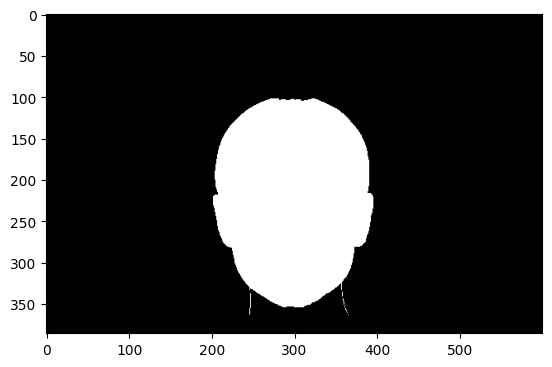

In [132]:
# display face mask
plt.imshow(mask2, cmap='gray')
plt.show()

#### Smoothen the mask using Gaussian Blurring

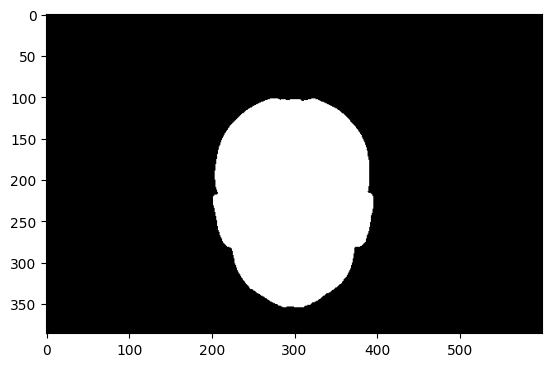

In [133]:
# smoothen the mask with a gaussian filter
mask2 = cv2.GaussianBlur(mask2, (5, 5), 0)
plt.imshow(mask2, cmap='gray')
plt.show()

### Face Landmarks


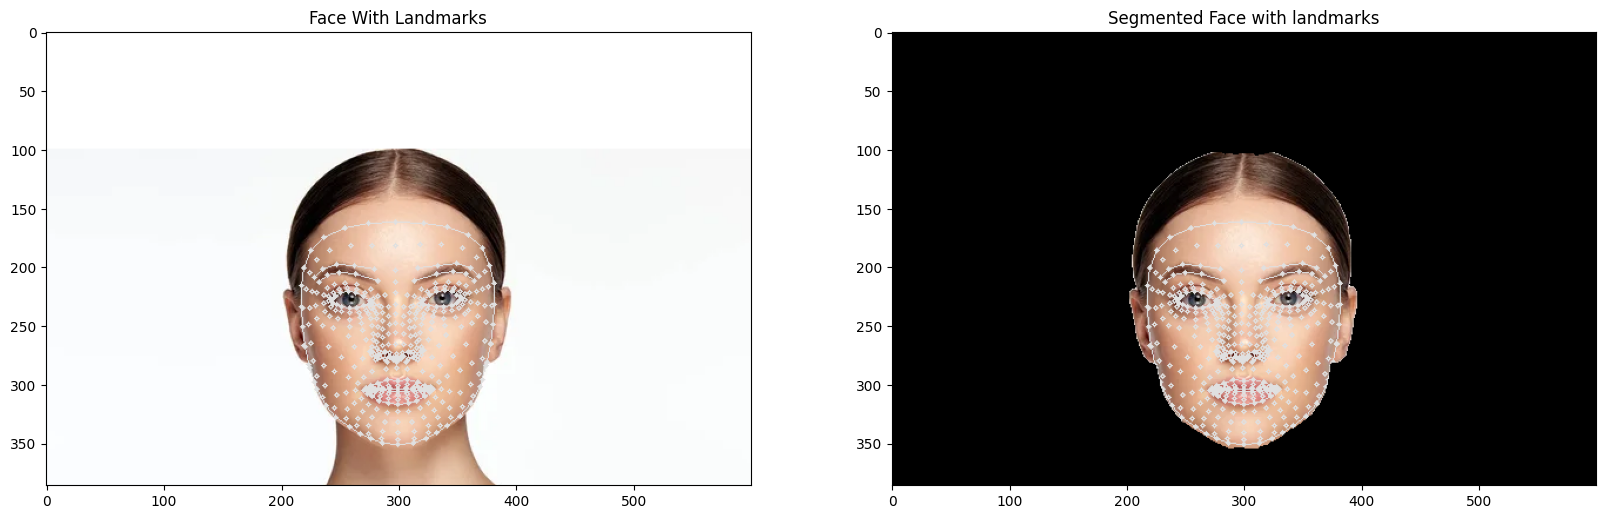

In [134]:
mpDraw = mp.solutions.drawing_utils
mpFaceMesh = mp.solutions.face_mesh
face_mesh = mpFaceMesh.FaceMesh(max_num_faces=1)
drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=1)

face_copy = np.copy(face)
landmarks = face_mesh.process(face_copy)
if landmarks.multi_face_landmarks:
    for face_landmarks in landmarks.multi_face_landmarks:
        landmarks_extracted = []
        for index in landmark_points_68:
            x = int(face_landmarks.landmark[index].x * face.shape[1])
            y = int(face_landmarks.landmark[index].y * face.shape[0])
            landmarks_extracted.append((x, y))
        mpDraw.draw_landmarks(face_copy, face_landmarks, mpFaceMesh.FACEMESH_CONTOURS, drawSpec, drawSpec)


segmented_face = np.multiply(face_copy, mask2[:, :, np.newaxis])
plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.title("Face With Landmarks")
plt.imshow(face_copy)
plt.subplot(1,2,2)
plt.title("Segmented Face with landmarks")
plt.imshow(segmented_face)
plt.show()

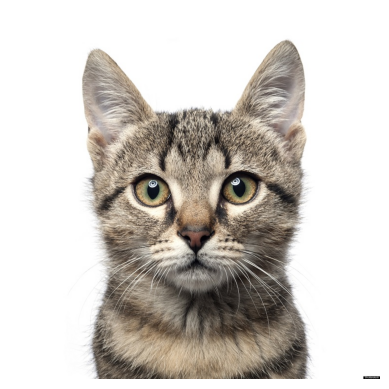

In [135]:
mat = sio.loadmat(f'../mask_files/{mask_name}.mat')

santa = mat['Imask']
face_map = mat['Imask_map'].astype(np.float32)
# face_map[face_map<127] = 0
# face_map[face_map>=127] = 255
hat_map = mat['Imask_map_hat'].astype(np.float32)
# hat_map[hat_map<127] = 0
# hat_map[hat_map>=127] = 255

x_coords, y_coords = mat['landmark_points_array_mask'][0][0]

santa_landmarks = []
for i in range(len(x_coords)):
    santa_landmarks.append([x_coords[i], y_coords[i]])

plt.imshow(santa)
plt.axis('off')
plt.show()

In [136]:
# for i in mat:
#     if i.startswith('Imask'):
#         continue
#     print(i, mat[i])

(['__header__', '__version__', '__globals__', 'Imask', 'Imask_map', 'Imask_map_hat', 'TempK', 'a', 'add_hat', 'add_vignetting', 'amp', 'avoid_artifacts', 'change_color_temp', 'effect', 'effect_img', 'face_mask', 'filt', 'gradient_blur', 'hat_c', 'hat_line', 'hat_w', 'landmark_points_array_mask', 'makeEyeHoles'])

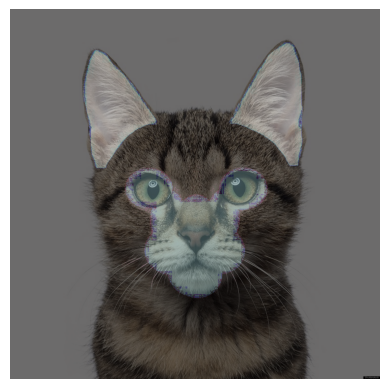

In [137]:
map1 = np.array(cv2.normalize(face_map, None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
map1 = cv2.applyColorMap(map1, cv2.COLORMAP_MAGMA)

map2 = np.array(cv2.normalize(hat_map, None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
map2 = cv2.applyColorMap(map2, cv2.COLORMAP_HOT)

blended = cv2.addWeighted(santa, 0.6, map1, 0.4, 0)
blended = cv2.addWeighted(blended, 0.7, map2, 0.3, 0)

plt.imshow(blended)
plt.axis('off')
plt.show()

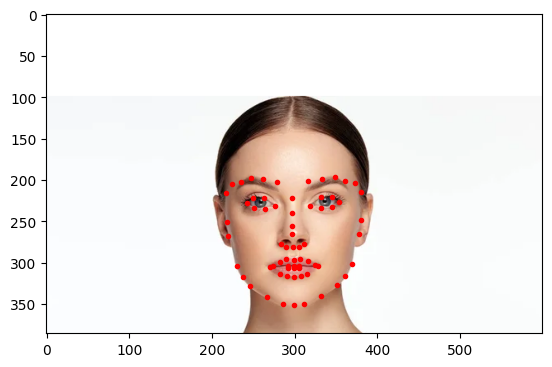

In [138]:
# plt.figure(figsize=(10, 10), dpi=500)
plt.imshow(face)

landmarks_extracted = np.array(landmarks_extracted)
plt.scatter(landmarks_extracted[:, 0], landmarks_extracted[:,1], color='red', marker='.')
# for i, (x, y) in enumerate(zip(x_coords, y_coords)):
#     plt.annotate(i+1, (x, y), color='red')

plt.show()

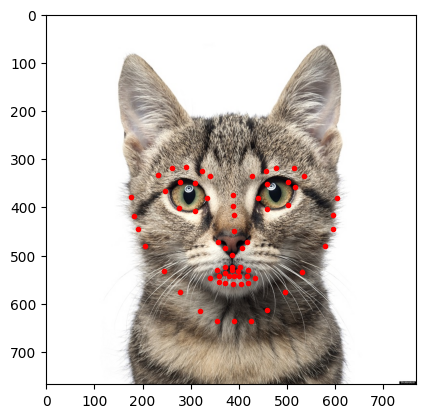

In [139]:
# plt.figure(figsize=(10, 10), dpi=500)
plt.imshow(mat['Imask'])

plt.scatter(x_coords, y_coords, color='red', marker='.')
# for i, (x, y) in enumerate(zip(x_coords, y_coords)):
#     plt.annotate(i+1, (x, y), color='red')

plt.show()

In [140]:
warp_trans = skimage.transform.PiecewiseAffineTransform()
warp_trans.estimate(landmarks_extracted, np.array(santa_landmarks))

True

In [141]:
santa1 = np.copy(santa)

warped_santa = skimage.transform.warp(santa1, warp_trans, output_shape=face.shape)
warped_santa = warped_santa.astype(np.float32)

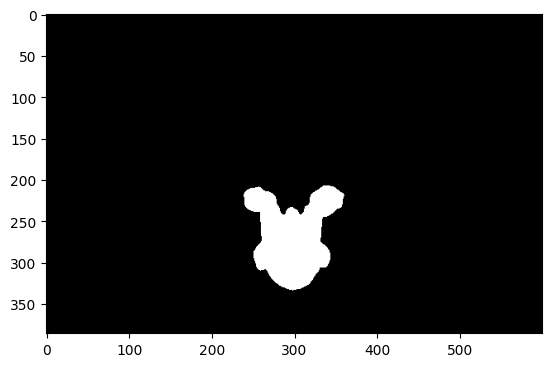

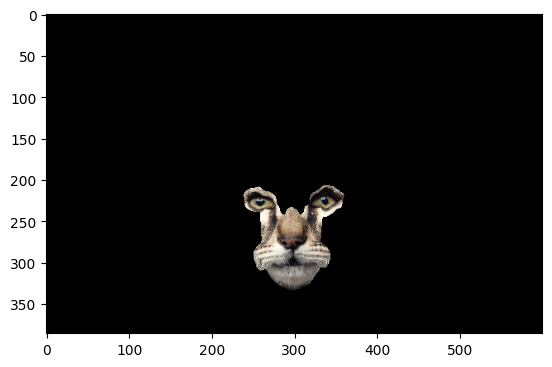

In [142]:
face_map1 = cv2.cvtColor(face_map, cv2.COLOR_GRAY2BGR).astype(np.float32)
warped_face_map = skimage.transform.warp(face_map1, warp_trans, output_shape=face.shape)
warped_face_map = warped_face_map.astype(np.float32)

warped_face_map = cv2.GaussianBlur(warped_face_map, (9, 9), 0)

warped_face_map[warped_face_map<127] = 0
warped_face_map[warped_face_map>=127] = 255
plt.imshow(warped_face_map.astype(np.uint8))
plt.show()

# Print segmented warped face
warped_santa1 = np.copy(warped_santa)
warped_santa1[warped_face_map < 127] = 0
plt.imshow(warped_santa1)
plt.show()

In [143]:
def hideEyes(I, p, hide=True):
    # Create binary masks for the left and right eye regions
    bw1 = cv2.fillPoly(np.zeros(I.shape[:2], dtype=np.uint8), [np.int32(p[36:42])], 1)
    bw2 = cv2.fillPoly(np.zeros(I.shape[:2], dtype=np.uint8), [np.int32(p[42:48])], 1)
    bw = np.maximum(bw1, bw2)

    # bw = cv2.dilate(bw, np.ones((5, 5), np.uint8), iterations=1)
    bw = cv2.GaussianBlur(bw, (5, 5), 0)
    bw = bw[:I.shape[0], :I.shape[1]]

    bw[bw < 0.5] = 0
    bw[bw >= 0.5] = 1
    bw = bw.astype(bool)

    if hide:
        for c in range(I.shape[2]):
            I[:, :, c][bw] = 0

    return I.astype(np.float32)

In [144]:
# blended_face1 = face.copy().astype(np.float32) / 255.0
# blended_face1[warped_face_map>127] = cv2.addWeighted(blended_face1, mat['a'][0][0], warped_santa1, 1-mat['a'][0][0], 0)[warped_face_map>127]
# # blended_face[warped_face_map>127] = warped_santa1[warped_face_map>127]

# # plt.figure(figsize=(10, 10))
# plt.imshow(blended_face1)
# plt.show()


"""Implementation without eye holes function"""

'Implementation without eye holes function'

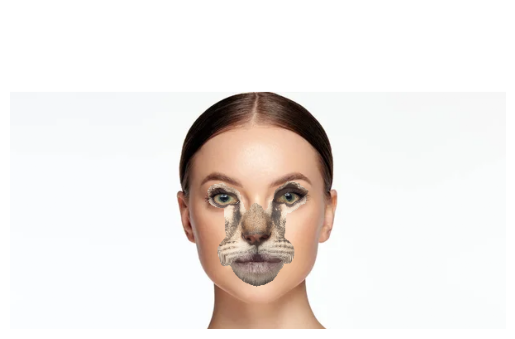

In [145]:
a = hideEyes(warped_face_map.copy(), landmarks_extracted, hide=bool(mat['makeEyeHoles'][0][0]))

# print((a==warped_face_map).all())

blended_face = face.copy().astype(np.float32) / 255.0
blended_face[a > 127] = cv2.addWeighted(blended_face, mat['a'][0][0], warped_santa1, 1-mat['a'][0][0], 0)[a>127]

# plt.figure(figsize=(10, 10))
plt.imshow(blended_face)
plt.axis('off')
plt.show()

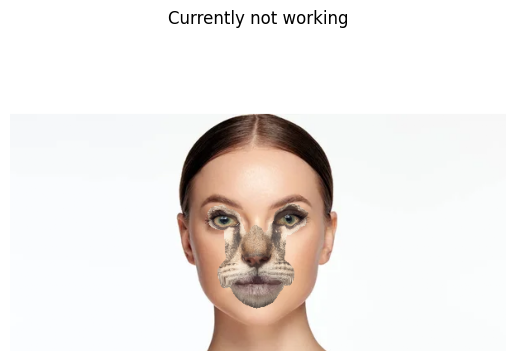

In [146]:
warped_face_mask = warped_face_map.astype(np.uint8)
edges = cv2.Canny(warped_face_mask, 0, 250)
mean_filtered_edges = cv2.blur(edges, (5, 5))

blended_face[mean_filtered_edges > 127] = cv2.GaussianBlur(blended_face, (9, 9), 0)[mean_filtered_edges > 127]

# plt.figure(figsize=(10, 10))
plt.imshow(blended_face)
plt.title("Currently not working")
plt.axis('off')
plt.show()

Face width: 164.00, Hat width: 768.00, Scale: 0.45
Eye angle: 0.00, Rotation angle: 0.00
Face center: [297. 227.]
Affine matrix: [[  0.44565217   0.         164.64130435]
 [ -0.           0.44565217 125.83695652]]


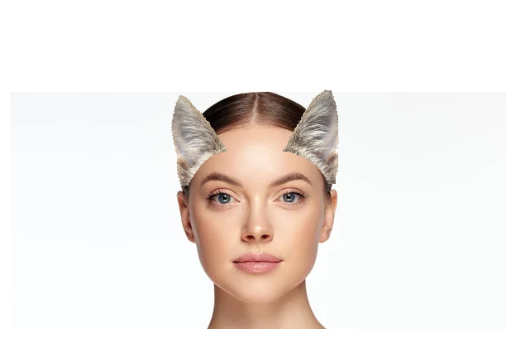

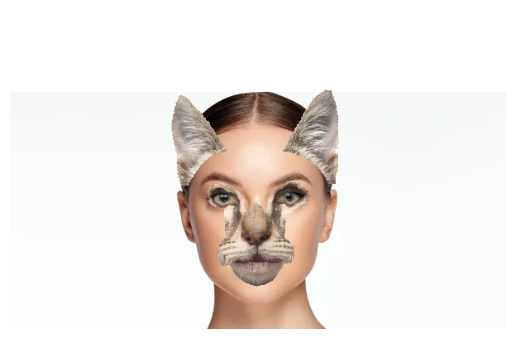

In [156]:


# Define the face landmarks and the hat map
face_landmarks = landmarks_extracted


# fill the black pixels with with white
# Calculate the scale from the width of the face
face_width = np.abs(face_landmarks[16][0] - face_landmarks[0][0])
#  find first white pixel from left and right of hat_map
#  calculate the distance between them
hat_map = mat['Imask_map_hat'].astype(np.float32)
hat_width = np.abs(np.where(hat_map[:, :]==255)[1][0] - np.where(hat_map[:, :]==255)[1][-1])
scale = face_width / hat_width

print(f"Face width: {face_width:.2f}, Hat width: {hat_map.shape[1]:.2f}, Scale: {scale:.2f}")
# # Calculate the rotation angle from the angle of the eyes
eye_angle = np.arctan2(face_landmarks[27][1] - face_landmarks[37][1], face_landmarks[27][0] - face_landmarks[37][0])
rotation_angle = np.degrees(eye_angle)

print(f"Eye angle: {eye_angle:.2f}, Rotation angle: {rotation_angle:.2f}")

# # Calculate the translation from the center of eyes of the face
# Calculate the face_center using the midpoint of the eyes
eye_midpoint = (face_landmarks[37] + face_landmarks[46]) // 2
face_center = eye_midpoint.astype(np.float64)


x_coords, y_coords = mat['landmark_points_array_mask'][0][0]
cat_landmarks = np.array(list(zip(x_coords, y_coords)))
cat_eye_midpoint = (cat_landmarks[36] + cat_landmarks[45]) // 2
hat_center = cat_eye_midpoint.astype(np.float64)

cat_face = mat['Imask']


# translation = face_center - hat_center


print(f"Face center: {face_center}")

# # Create the affine matrix
affine_matrix = cv2.getRotationMatrix2D(tuple(face_center), rotation_angle, scale)



print(f"Affine matrix: {affine_matrix}")
hat_center_transformed = affine_matrix.dot(np.array([hat_center[0], hat_center[1], 1]))
translation = face_center - hat_center_transformed

affine_matrix[:, 2] += translation




# # Apply the affine transformation to the hat map
hat_map_transformed = cv2.warpAffine(hat_map, affine_matrix, (face.shape[1], face.shape[0]))

# # Display the transformed hat map
cat_face_transformed = cv2.warpAffine(cat_face, affine_matrix, (face.shape[1], face.shape[0]))



# apply hat mask to cat_face
cat_face_transformed[hat_map_transformed < 127] = 0

face_copy = np.copy(face)
# apply cat_face_transformed to face_copy
face_copy[hat_map_transformed > 127] = cat_face_transformed[hat_map_transformed > 127]

# plt.figure(figsize=(10, 10))
plt.imshow(face_copy)
plt.axis('off')
plt.show()

blended_face = face.copy().astype(np.float32) / 255.0
blended_face[a > 127] = cv2.addWeighted(blended_face, mat['a'][0][0], warped_santa1, 1-mat['a'][0][0], 0)[a>127]
blended_face[hat_map_transformed > 127] = (cat_face_transformed[hat_map_transformed > 127])/255.0


plt.imshow(blended_face)
plt.axis('off')
plt.show()


